In [350]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [ ]:
x = 2021

url = f"https://fbref.com/en/comps/19/{x}-{x+1}/schedule/{x}-{x+1}-Europa-League-Scores-and-Fixtures"
# url = f'https://fbref.com/en/comps/8/{x}-{x+1}/schedule/{x}-{x+1}-Champions-League-Scores-and-Fixtures'
# url = f'https://fbref.com/en/comps/882/{x}-{x+1}/schedule/{x}-{x+1}-Conference-League-Scores-and-Fixtures'

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

response = requests.get(url, headers=headers)

soup = BeautifulSoup(response.text, "html.parser")

In [352]:
table = soup.find("table", {"class": "stats_table"})

header_row = table.find("thead").find("tr") if table.find("thead") else table.find("tr")
headers = [th.text.strip() for th in header_row.find_all("th")]

# Extract rows
rows = []
for tr in table.find("tbody").find_all("tr"):  # Use tbody to avoid header rows
    cells = [td.text.strip() for td in tr.find_all("td")]
    if cells:  # Ignore empty rows
        rows.append(cells)

# Ensure column and row lengths match
if len(headers) > len(rows[0]):  # If there are extra headers
    headers = headers[-len(rows[0]):]  # Use only the last N headers matching the data

# Convert to DataFrame
df = pd.DataFrame(rows, columns=headers)

df[['Home', 'Home_Country']] = df['Home'].str.rsplit(n=1, expand=True)
df[['Away_Country', 'Away']] = df['Away'].str.split(n=1, expand=True)

df = df[['Date', 'Home', 'Away', 'Home_Country', 'Away_Country', 'Score']]

df.columns = ['date', 'hometeam', 'awayteam', 'homecountry', 'awaycountry', 'score']

df['score'] = df['score'].str.replace(r'\(.*?\)\s*', '', regex=True)

df[['homescore', 'awayscore']] = df['score'].str.split('–', expand=True)

# Convert the score columns to numeric
df['homescore'] = pd.to_numeric(df['homescore'])
df['awayscore'] = pd.to_numeric(df['awayscore'])

# Create a new column for match result
df['result'] = df.apply(
    lambda row: 0 if row['homescore'] > row['awayscore'] else (0.5 if row['homescore'] == row['awayscore'] else 1),
    axis=1
)

df.drop(columns=['score'], inplace=True)

df.dropna(inplace=True)

In [ ]:
df.to_csv(f'europe/europa_league/{x}-{x+1}.csv')

In [24]:
import os
import pandas as pd

# Directory containing all the CSV files
directory = 'europe/conference_league/'

# List all CSV files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Initialize an empty list to store dataframes
dfs = []

# Loop through all CSV files and read them into a DataFrame
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path, index_col=False)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    dfs.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

# Save the combined DataFrame to a new CSV
combined_df.to_csv('europe/conference_league_all_seasons_combined.csv', index=False)

In [25]:
import os
import pandas as pd

# Directories containing the CSV files
directories = [
    ('europe/', 'Champions League'),
    ('europe/', 'Europa League'),
    ('europe/', 'Conference League')
]

# Initialize an empty list to store dataframes
dfs = []

# Loop through each directory and competition name
for directory, competition in directories:
    # List all CSV files in the directory
    csv_files = [f for f in os.listdir(directory) if f.endswith('all_seasons_combined.csv')]

    # Loop through all CSV files and read them into a DataFrame
    for file in csv_files:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)

        # Add a new column for the competition name
        df['Competition'] = competition

        # Optionally, drop any 'Unnamed' columns if they exist
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

combined_df.sort_values('date', inplace=True)

combined_df['result'] = 1 - combined_df['result']

# Save the combined DataFrame to a new CSV
combined_df.to_csv('europe/all_competitions_combined.csv', index=False, encoding='utf-8')

In [26]:
import json

# Load the country code mapping JSON
with open('europe/country_codes.json', 'r', encoding='utf-8') as f:
    country_codes = json.load(f)

df = combined_df

df['homecountry_name'] = df['homecountry'].map(country_codes)
df['awaycountry_name'] = df['awaycountry'].map(country_codes)

# Display the updated DataFrame
df

,date,hometeam,awayteam,homecountry,awaycountry,homescore,awayscore,result,Competition,homecountry_name,awaycountry_name
0,1990-09-18,Odense,Real Madrid,dk,es,1.0,4.0,0.0,Champions League,Denmark,Spain
26382,1990-09-18,Sporting CP,Mechelen,pt,be,1.0,0.0,1.0,Conference League,Portugal,Belgium
26381,1990-09-18,Glenavon FC,Bordeaux,nir,fr,0.0,0.0,0.5,Conference League,Northern Ireland,France
26380,1990-09-18,Hibernians FC,Partizan,mt,rs,0.0,3.0,0.0,Conference League,Malta,Serbia
26379,1990-09-18,FC Avenir Beggen,Inter Bratislava,lu,sk,2.0,1.0,1.0,Conference League,Luxembourg,Slovakia
...,...,...,...,...,...,...,...,...,...,...,...
14948,2025-02-18,Milan,Feyenoord,it,nl,1.0,1.0,0.5,Europa League,Italy,Netherlands
4061,2025-02-18,Milan,Feyenoord,it,nl,1.0,1.0,0.5,Champions League,Italy,Netherlands
14949,2025-02-18,Benfica,Monaco,pt,fr,3.0,3.0,0.5,Europa League,Portugal,France
25837,2025-02-18,Bayern Munich,Celtic,de,sct,1.0,1.0,0.5,Conference League,Germany,Scotland


In [51]:
import pandas as pd

df = df[df['date']>'2005-01-01']

initial_elo = 1500
elo_ratings = {}
match_counts = {}  # Track number of matches per country

def calculate_elo(home_country, away_country, result, elo_ratings, match_counts, K_base=30, min_matches=50):
    # Ensure both countries are in Elo dictionary
    if home_country not in elo_ratings:
        elo_ratings[home_country] = initial_elo
        match_counts[home_country] = 0  # Initialize match count
    
    if away_country not in elo_ratings:
        elo_ratings[away_country] = initial_elo
        match_counts[away_country] = 0  # Initialize match count

    home_elo = elo_ratings[home_country]
    away_elo = elo_ratings[away_country]

    # Dynamic K-factor: More matches → lower K, fewer matches → higher K
    home_K = K_base / (1 + match_counts[home_country] / min_matches)
    away_K = K_base / (1 + match_counts[away_country] / min_matches)

    # Calculate expected scores
    expected_home = 1 / (1 + 10 ** ((away_elo - home_elo) / 400))
    expected_away = 1 / (1 + 10 ** ((home_elo - away_elo) / 400))

    # Actual match result scoring
    actual_home, actual_away = (1, 0) if result == 1 else (0, 1) if result == 0 else (0.5, 0.5)

    # Elo updates
    new_home_elo = home_elo + home_K * (actual_home - expected_home)
    new_away_elo = away_elo + away_K * (actual_away - expected_away)

    # Update Elo ratings and match counts
    elo_ratings[home_country] = new_home_elo
    elo_ratings[away_country] = new_away_elo
    match_counts[home_country] += 1
    match_counts[away_country] += 1

    return elo_ratings, match_counts

# Process each match
for index, row in df.iterrows():
    home_country = row['homecountry_name']
    away_country = row['awaycountry_name']
    result = row['result']
    elo_ratings, match_counts = calculate_elo(home_country, away_country, result, elo_ratings, match_counts)

# Sort Elo rankings
elo_ranking = sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)

# Create DataFrame for final ranking
elo_df = pd.DataFrame(elo_ranking, columns=['Country', 'Elo Rating'])

elo_df["Elo Normalized"] = (elo_df["Elo Rating"] - elo_df["Elo Rating"].min()) / (elo_df["Elo Rating"].max() - elo_df["Elo Rating"].min())

elo_df

,Country,Elo Rating,Elo Normalized
0,England,1666.516181,1.000000
1,Spain,1651.340024,0.960206
2,Italy,1621.489820,0.881933
3,Germany,1618.558473,0.874247
4,France,1572.236650,0.752783
5,Portugal,1562.011157,0.725970
6,Netherlands,1557.611979,0.714435
7,Russia,1524.981278,0.628872
8,Belgium,1514.827998,0.602248
9,Ukraine,1495.564644,0.551736


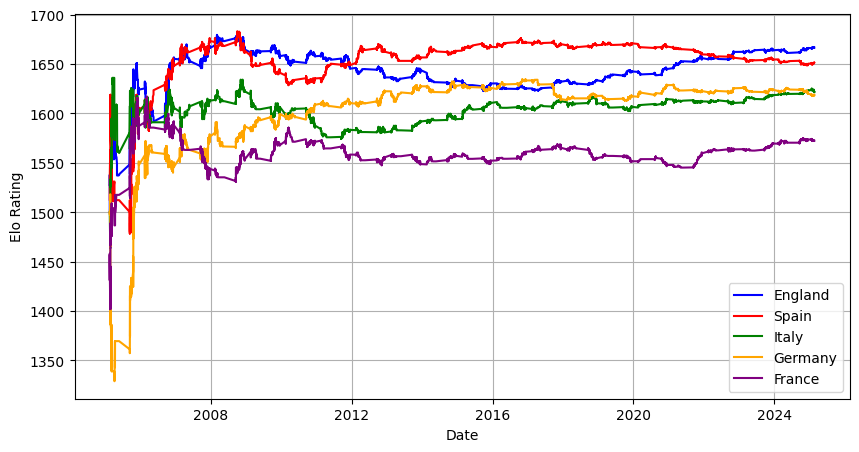

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

initial_elo = 1500
elo_ratings = {}
match_counts = {}
elo_history = []  # Track Elo evolution over time

def calculate_elo(home_country, away_country, result, elo_ratings, match_counts, K_base=30, min_matches=50):
    # Ensure both countries are in Elo dictionary
    if home_country not in elo_ratings:
        elo_ratings[home_country] = initial_elo
        match_counts[home_country] = 0
    
    if away_country not in elo_ratings:
        elo_ratings[away_country] = initial_elo
        match_counts[away_country] = 0

    home_elo = elo_ratings[home_country]
    away_elo = elo_ratings[away_country]

    # Dynamic K-factor
    home_K = K_base / (1 + match_counts[home_country] / min_matches)
    away_K = K_base / (1 + match_counts[away_country] / min_matches)

    # Expected scores
    expected_home = 1 / (1 + 10 ** ((away_elo - home_elo) / 400))
    expected_away = 1 / (1 + 10 ** ((home_elo - away_elo) / 400))

    # Actual result
    actual_home, actual_away = (1, 0) if result == 1 else (0, 1) if result == 0 else (0.5, 0.5)

    # Elo updates
    new_home_elo = home_elo + home_K * (actual_home - expected_home)
    new_away_elo = away_elo + away_K * (actual_away - expected_away)

    # Store new ratings
    elo_ratings[home_country] = new_home_elo
    elo_ratings[away_country] = new_away_elo
    match_counts[home_country] += 1
    match_counts[away_country] += 1

    return elo_ratings, match_counts

# Process each match
for index, row in df.iterrows():
    home_country = row['homecountry_name']
    away_country = row['awaycountry_name']
    result = row['result']
    match_date = row['date']  # Store date for graph tracking

    # Update Elo ratings
    elo_ratings, match_counts = calculate_elo(home_country, away_country, result, elo_ratings, match_counts)

    # Track evolution for England and Spain
    if "England" in elo_ratings and "Spain" in elo_ratings:
        elo_history.append({
            "date": match_date,
            "England": elo_ratings["England"],
            "Spain": elo_ratings["Spain"],
            "Italy": elo_ratings["Italy"],
            "Germany": elo_ratings["Germany"],
            "France": elo_ratings["France"]
        })

# Convert Elo history to DataFrame
elo_evolution_df = pd.DataFrame(elo_history)
elo_evolution_df["date"] = pd.to_datetime(elo_evolution_df["date"])  # Convert dates
elo_evolution_df = elo_evolution_df.sort_values("date")  # Sort by date

# Plot Elo evolution
plt.figure(figsize=(10, 5))
plt.plot(elo_evolution_df["date"], elo_evolution_df["England"], label="England", color="blue")
plt.plot(elo_evolution_df["date"], elo_evolution_df["Spain"], label="Spain", color="red")
plt.plot(elo_evolution_df["date"], elo_evolution_df["Italy"], label="Italy", color="green")
plt.plot(elo_evolution_df["date"], elo_evolution_df["Germany"], label="Germany", color="orange")
plt.plot(elo_evolution_df["date"], elo_evolution_df["France"], label="France", color="purple")

plt.xlabel("Date")
plt.ylabel("Elo Rating")
plt.legend()
plt.grid(True)
plt.show()
